# High percentile precipitation rate - one model

In [1]:
import xarray as xr
import numpy as np
import skimage.measure as skm
import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeat

from os.path import expanduser
home = expanduser("~")

import timeit

In [2]:
models = [
    # 'IPSL-CM5A-MR', # 1
    'GFDL-CM3',     
    # 'GISS-E2-H',    # 3
    # 'bcc-csm1-1',   # 4
    # 'CNRM-CM5',     # 5
    # 'CCSM4',        # 6 # cannot concatanate files for rcp85 run
    # 'HadGEM2-AO',   # 7
    # 'BNU-ESM',      # 8
    # 'EC-EARTH',     # 9
    # 'FGOALS-g2',    # 10
    # 'MPI-ESM-MR',   # 11
    # 'CMCC-CM',      # 12
    # 'inmcm4',       # 13
    # 'NorESM1-M',    # 14
    # 'CanESM2',      # 15
    # 'MIROC5',       # 16
    # 'HadGEM2-CC',   # 17
    # 'MRI-CGCM3',    # 18
    # 'CESM1-BGC'     # 19
    ]
model = models[0]


experiments = [
    'historical',
    # 'rcp85'
    ]
experiment = experiments[0]       



if switch['local_files']:
    folder = home + '/Documents/data/cmip5/' + 'ds'
    fileName = model + '_precip_' + experiment + '.nc'
    path = folder + '/' + fileName
    ds = xr.open_dataset(path)
    precip = ds.precip*60*60*24
    precip.attrs['units']= 'mm/day'

if switch['nci_files']:
    precip = get_pr(model, experiment).precip # from prVars


# precip
# plot_snapshot(precip.isel(time=0), 'Blues', 'precip', model) # from vars.myPlots


In [3]:
start = timeit.default_timer()
pr_percentiles = calc_pr_percentiles(precip) # from prFuncs
stop = timeit.default_timer()
print('it takes {} seconds to calculate extreme percentiles for model: {}'.format((stop-start)/60, model))

it takes 0.036197220833333335 seconds to calculate extreme percentiles for model: GFDL-CM3


In [4]:
pr_percentiles

<xarray.Dataset>
Dimensions:  (time: 10950)
Coordinates:
  * time     (time) object 1970-01-01 12:00:00 ... 1999-12-31 12:00:00
Data variables:
    pr95     (time) float64 14.08 13.81 14.17 14.02 ... 16.82 16.76 16.91 15.32
    pr97     (time) float64 17.44 17.1 17.44 17.31 ... 20.42 21.26 21.76 19.81
    pr99     (time) float64 25.16 28.12 26.33 25.34 ... 25.66 29.67 33.37 31.73
    pr999    (time) float64 46.43 56.0 75.17 68.38 ... 41.02 47.47 67.33 72.96

In [5]:
pr_percentile = pr_percentiles.pr99

In [6]:
# plot_snapshot(precip.isel(time=0).where(precip.isel(time=0)>=pr_percentiles.pr95.mean(dim='time')),'Blues', '95th percentile', model)

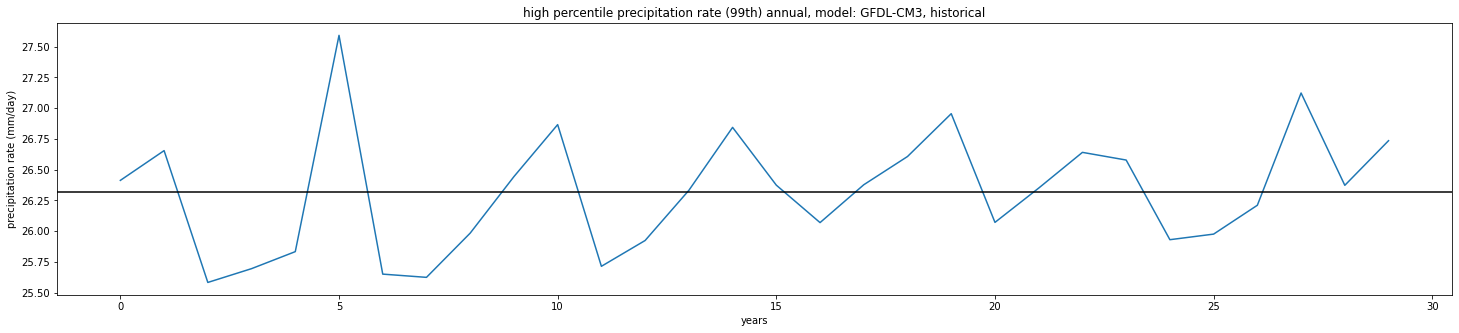

In [7]:
plt.figure(figsize= (25,5))
plt.plot(pr_percentile.resample(time='Y').mean(dim='time'))
plt.title('high percentile precipitation rate ({}th) annual'.format('99') + ', model: ' + model + ', ' + experiment)
plt.ylabel('precipitation rate (mm/day)')
plt.xlabel('years')
plt.axhline(y=pr_percentile.resample(time='Y').mean(dim='time').mean(dim='time'), color='k')

In [8]:
pr_percentileSeason = pr_percentile.resample(time='QS-DEC').mean(dim="time")

In [9]:
def to_monthly(da):
    year = da.time.dt.year
    month = da.time.dt.month

    # assign new coords
    da = da.assign_coords(year=("time", year.data), month=("time", month.data))

    # reshape the array to (..., "month", "year")
    return da.set_index(time=("year", "month")).unstack("time")

In [10]:
pr_percentileSeason = to_monthly(pr_percentileSeason)

In [11]:
# 3 - MAM
# 6 - JJA
# 9 - SON
# 12 - DJF
pr_percentileSeason = pr_percentileSeason.rename({'month':'season'})
pr_percentileSeason = pr_percentileSeason.assign_coords(season = ["MAM", "JJA", "SON", "DJF"])

Text(0.5, 1.0, 'high percentile precipitation rate (99th) by season, model: GFDL-CM3, historical')

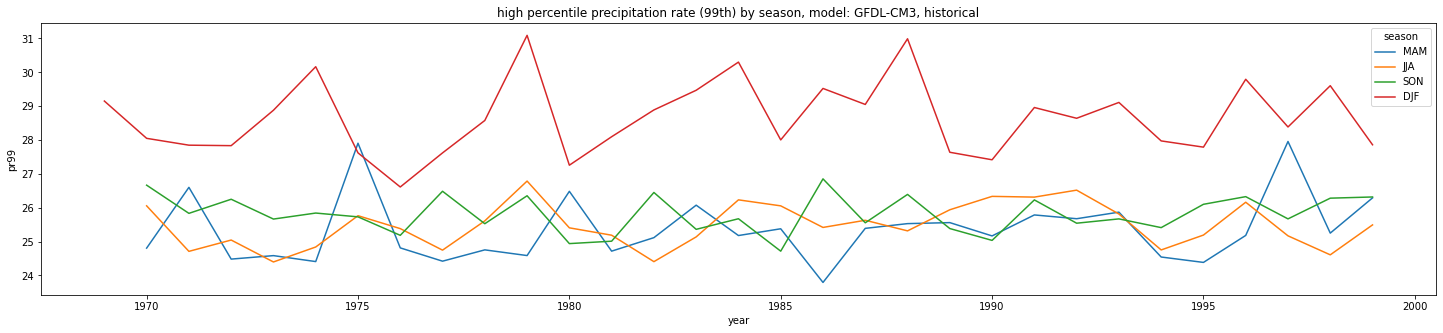

In [12]:
pr_percentileSeason.plot(x='year', hue='season', figsize=(25,5))
plt.title('high percentile precipitation rate ({}th) by season'.format('99') + ', model: ' + model + ', ' + experiment)

In [13]:
pr_percentileMonthly = to_monthly(pr_percentiles.pr99)
pr_percentileMonthly = pr_percentileMonthly.assign_coords(month = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul','aug', 'sep', 'oct', 'nov', 'dec'])

In [14]:
# from cycler import cycler
# colors = plt.cm.RdBu(np.linspace(0, 1, 12))
# colors = np.roll(colors, -1, axis=0)
# #colors = np.concatenate((colors[1:], [colors[0]]))
# custom_cycler = cycler(color=colors)
# f, ax = plt.subplots(figsize = (25,5))
# ax.set_prop_cycle(custom_cycler)

# pr_percentileMonthly.plot(ax=ax, x='year', hue='month')
# plt.title('high percentile precipitation rate ({}) by month'.format('99'))


Text(0.5, 1.0, 'high percentile precipitation rate (99th) by month, model: GFDL-CM3, historical')

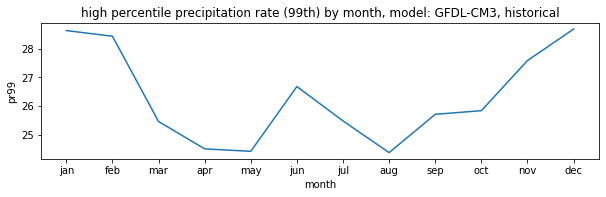

In [15]:
pr_percentileMonthly.mean(dim='year').plot(figsize = (10,2.5))
plt.title('high percentile precipitation rate ({}th) by month'.format('99') + ', model: ' + model + ', ' + experiment)

Text(0, 0.5, 'pr99 (mm/day)')

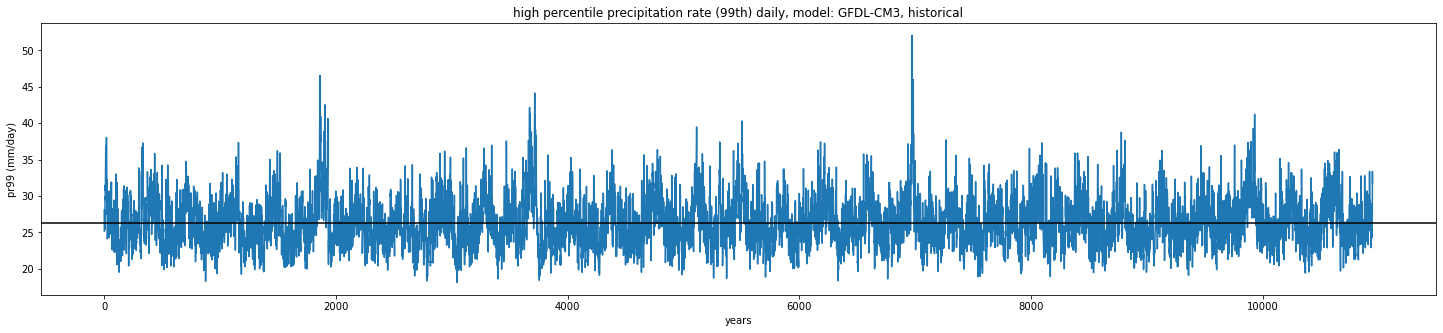

In [16]:
f, ax = plt.subplots(figsize = (25,5))
ax.plot(pr_percentiles.pr99)
ax.axhline(y=pr_percentiles.pr99.mean(dim='time'), color='k')
ax.set_title('high percentile precipitation rate ({}th) daily'.format('99') + ', model: ' + model + ', ' + experiment)
#ax.set_ylim(0,100)
ax.set_xlabel('years')
ax.set_ylabel('pr99 (mm/day)')